# Basic GAN + Postprocessing 


## 1. Hyperparameters


In [1]:
import os
import random
import torch
import numpy as np

# -------- Paths & Hyperparameters --------
DATA_ROOT      = "/Users/shiyaogu/Documents/GAN/TD2/set2"
IMG_SIZE       = 64
IMG_CHANNELS   = 1
Z_DIM          = 128
G_FEATURES     = 64
D_FEATURES     = 64
BATCH_SIZE     = 256       # 256-512 if enough GPU memory
LR             = 2e-4
BETAS          = (0.5, 0.999)
EPOCHS         = 25
NUM_WORKERS    = 0             
PIN_MEMORY     = (torch.cuda.is_available())     
PERSISTENT     = False

SAMPLE_EVERY   = 200
SAVE_EVERY_EPK = 1

# -------- Outputs --------
OUTPUT_DIR     = "./outputs_dcgan"
SAMPLES_DIR    = os.path.join(OUTPUT_DIR, "samples")
CKPT_DIR       = os.path.join(OUTPUT_DIR, "checkpoints")
os.makedirs(SAMPLES_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)

# -------- Device --------
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# -------- Seeds --------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)


Using device: mps


In [2]:

# === Regularization & TTUR additions (English comments) ===
# If you already defined LR/BATCH_SIZE/others above, this cell can override only what's below.

# Regularization weights for generator loss (start small; tune gradually)
LAMBDA_TV     = globals().get("LAMBDA_TV", 1e-5)   # Total Variation
LAMBDA_PSD    = globals().get("LAMBDA_PSD", 1e-3)  # Radial PSD matching
LAMBDA_EDGE   = globals().get("LAMBDA_EDGE", 0.0)  # Sobel edge sparsity (optional)

# TTUR learning rates (keep if already defined; otherwise set here)
LR_G = globals().get("LR_G", 2e-4)  # Generator LR
LR_D = globals().get("LR_D", 4e-4)  # Discriminator LR (slightly larger for hinge-GAN)
BETA1 = globals().get("BETA1", 0.0)
BETA2 = globals().get("BETA2", 0.9)

print(f"Regularization configured: TV={LAMBDA_TV}, PSD={LAMBDA_PSD}, EDGE={LAMBDA_EDGE}")
print(f"TTUR: LR_G={LR_G}, LR_D={LR_D}, betas=({BETA1},{BETA2})")

Regularization configured: TV=1e-05, PSD=0.001, EDGE=0.0
TTUR: LR_G=0.0002, LR_D=0.0004, betas=(0.0,0.9)


## 2. Data loading
We implement a tiny dataset class that:
- Recursively scans for `.png` files
- Converts any PNG to **RGB**
- Applies: `Resize(64) → CenterCrop(64) → ToTensor() → Normalize(mean=0.5, std=0.5)` so pixels lie in `[-1, 1]`


In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
from torchvision import transforms

class PNGImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = sorted(glob.glob(os.path.join(root_dir, "**", "*.png"), recursive=True))
        if len(self.paths) == 0:
            raise RuntimeError(f"No PNG images found under: {root_dir}")
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        with Image.open(path) as img:
            img = img.convert("L")
        if self.transform is not None:
            img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = PNGImageDataset(DATA_ROOT, transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=PERSISTENT
)
len(dataset)


14164

### Quick preview of real samples
A sanity check that the data pipeline works. `denorm` maps from `[-1,1]` back to `[0,1]` for display.


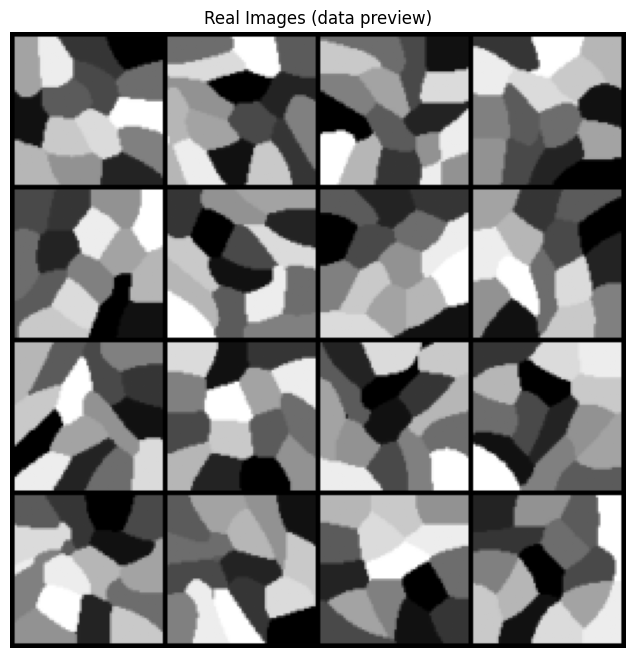

In [4]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def denorm(x):
    return (x * 0.5) + 0.5

real_batch = next(iter(dataloader))
grid = make_grid(denorm(real_batch[:16]), nrow=4, padding=2)

# 转换为 HWC 方便 imshow
img = grid.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images (data preview)")

if img.shape[-1] == 1:     # 灰度图
    plt.imshow(img[..., 0], cmap="gray")
else:                      # 彩色图 (RGB)
    plt.imshow(img)

plt.show()


## 3. Model architecture (DCGAN)
- **Generator** upsamples a latent vector `z ~ N(0, I)` via transposed convolutions to a 64×64 RGB image (final `tanh` to match data normalized to `[-1,1]`).
- **Discriminator** downsamples with convolutions to a 1×1 logit (use `BCEWithLogitsLoss` for stability).

In [5]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=128, g_feat=64, img_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, g_feat*8, 4, 1, 0, bias=False),  # 1x1 -> 4x4
            nn.BatchNorm2d(g_feat*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(g_feat*8, g_feat*4, 4, 2, 1, bias=False),  # 4x4 -> 8x8
            nn.BatchNorm2d(g_feat*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(g_feat*4, g_feat*2, 4, 2, 1, bias=False),  # 8x8 -> 16x16
            nn.BatchNorm2d(g_feat*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(g_feat*2, g_feat, 4, 2, 1, bias=False),    # 16x16 -> 32x32
            nn.BatchNorm2d(g_feat),
            nn.ReLU(True),

            nn.ConvTranspose2d(g_feat, img_channels, 4, 2, 1, bias=False), # 32x32 -> 64x64
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, d_feat=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, d_feat, 4, 2, 1, bias=False),     # 64x64 -> 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_feat, d_feat*2, 4, 2, 1, bias=False),         # 32x32 -> 16x16
            nn.BatchNorm2d(d_feat*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_feat*2, d_feat*4, 4, 2, 1, bias=False),       # 16x16 -> 8x8
            nn.BatchNorm2d(d_feat*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_feat*4, d_feat*8, 4, 2, 1, bias=False),       # 8x8 -> 4x4
            nn.BatchNorm2d(d_feat*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_feat*8, 1, 4, 1, 0, bias=False)               # 4x4 -> 1x1 logits
        )

    def forward(self, x):
        return self.net(x).view(-1)


## 4. Initialization, loss, optimizer
- **Init**: DCGAN-style (`Conv/ConvTranspose ~ N(0, 0.02)`, `BatchNorm weight ~ N(1,0.02)`, bias=0).  
- **Loss**: `BCEWithLogitsLoss`.  
- **Optimizer**: Adam with `betas=(0.5, 0.999)`.


In [6]:
import torch
import torch.nn as nn

def weights_init_dcgan(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G = Generator(z_dim=Z_DIM, g_feat=G_FEATURES, img_channels=IMG_CHANNELS).to(DEVICE)
D = Discriminator(img_channels=IMG_CHANNELS, d_feat=D_FEATURES).to(DEVICE)

G.apply(weights_init_dcgan)
D.apply(weights_init_dcgan)

criterion = nn.BCEWithLogitsLoss()
optG = torch.optim.Adam(G.parameters(), lr=LR, betas=BETAS)
optD = torch.optim.Adam(D.parameters(), lr=LR, betas=BETAS)

fixed_noise = torch.randn(64, Z_DIM, 1, 1, device=DEVICE)


## 5. Training loop
Per batch:
1. **Train D** on reals and fakes (maximize `log D(x)` and `log (1 - D(G(z)))`).
2. **Train G** to fool D (maximize `log D(G(z))`, i.e., minimize `BCE(D(G(z)), 1)`).

### Regularization utilities (TV / PSD / Edge sparsity)

In [7]:

# --- Regularization utilities (English comments) ---
import torch
import torch.nn.functional as F

def total_variation_loss(x):
    # x: (B,C,H,W) in [-1,1] or [0,1]
    dh = (x[:, :, 1:, :] - x[:, :, :-1, :]).pow(2).mean()
    dw = (x[:, :, :, 1:] - x[:, :, :, :-1]).pow(2).mean()
    return dh + dw

_radial_cache = {}
def _get_radial_index(h, w, device):
    key = (h, w, device)
    if key in _radial_cache:
        return _radial_cache[key]
    yy, xx = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij')
    cy, cx = (h-1)/2.0, (w-1)/2.0
    rr = torch.sqrt((yy - cy)**2 + (xx - cx)**2)
    r = rr.round().long().clamp(min=0)
    R = int(r.max().item()) + 1
    _radial_cache[key] = (r, R)
    return _radial_cache[key]

def radial_power_spectrum(images):
    # images: (B,1,H,W), any range; zero-centered internally
    B, C, H, W = images.shape
    assert C == 1, "PSD defined for grayscale (C=1)."
    x = images - images.mean(dim=(-2,-1), keepdim=True)
    F2 = torch.fft.fft2(x.squeeze(1))                      # (B,H,W), complex
    P  = (F2.real**2 + F2.imag**2) / (H*W)                 # power spectrum
    P  = torch.fft.fftshift(P, dim=(-2,-1))                # center
    r_idx, R = _get_radial_index(H, W, P.device)           # (H,W), R
    r_idx_flat = r_idx.flatten()[None, :].expand(B, -1)    # (B, HW)
    P_flat = P.flatten(1)                                  # (B, HW)
    psd = torch.zeros(B, R, device=P.device).scatter_add(1, r_idx_flat, P_flat)
    ones = torch.ones_like(P_flat)
    counts = torch.zeros(B, R, device=P.device).scatter_add(1, r_idx_flat, ones)
    psd = psd / (counts + 1e-8)
    return psd

def psd_matching_loss(fake, real):
    # Align radial power spectra between fake and real batches (soft constraint)
    psd_f = radial_power_spectrum(fake)
    psd_r = radial_power_spectrum(real)
    psd_f = psd_f / (psd_f.sum(dim=1, keepdim=True) + 1e-8)
    psd_r = psd_r / (psd_r.sum(dim=1, keepdim=True) + 1e-8)
    diff = psd_f.mean(0) - psd_r.mean(0)
    return (diff * diff).mean()

def _sobel_kernels(device):
    kx = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=torch.float32, device=device).view(1,1,3,3)
    ky = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=torch.float32, device=device).view(1,1,3,3)
    return kx, ky

def edge_sparsity_loss(x):
    # x: (B,1,H,W)
    kx, ky = _sobel_kernels(x.device)
    gx = F.conv2d(x, kx, padding=1)
    gy = F.conv2d(x, ky, padding=1)
    mag = torch.sqrt(gx*gx + gy*gy + 1e-8)
    return mag.mean()

def regularization_loss(fake, real=None, lambda_tv=0., lambda_psd=0., lambda_edge=0.):
    loss = torch.tensor(0., device=fake.device)
    if lambda_tv > 0:
        loss = loss + lambda_tv * total_variation_loss(fake)
    if lambda_psd > 0 and real is not None:
        loss = loss + lambda_psd * psd_matching_loss(fake, real)
    if lambda_edge > 0:
        loss = loss + lambda_edge * edge_sparsity_loss(fake)
    return loss


In [8]:

# === Training loop (hinge-GAN + TTUR + optional regularization) ===
import torch
import torch.nn.functional as F
from torchvision.utils import save_image

# Expect variables: train_loader, Generator (G), Discriminator (D), Z_DIM, IMG_CHANNELS, G_FEATURES, D_FEATURES
# Also uses: LR_G, LR_D, BETA1, BETA2, LAMBDA_TV, LAMBDA_PSD, LAMBDA_EDGE, SAMPLES_DIR

def init_models():
    G = Generator(Z_DIM, G_FEATURES, IMG_CHANNELS).to(DEVICE)
    D = Discriminator(D_FEATURES, IMG_CHANNELS).to(DEVICE)
    return G, D

def save_samples(G, step_or_epoch, n=64, out_dir=SAMPLES_DIR):
    G.eval()
    with torch.no_grad():
        z = torch.randn(n, Z_DIM, 1, 1, device=DEVICE)
        fake = G(z).clamp(-1,1).cpu()
    grid = (fake * 0.5 + 0.5)
    os.makedirs(out_dir, exist_ok=True)
    save_path = os.path.join(out_dir, f"samples_{step_or_epoch:06d}.png")
    save_image(grid, save_path, nrow=int(n**0.5))
    return save_path

def train_ttur_with_regularization(epochs=20, n_critic=1, save_every=1000):
    G, D = init_models()
    optG = torch.optim.Adam(G.parameters(), lr=LR_G, betas=(BETA1, BETA2))
    optD = torch.optim.Adam(D.parameters(), lr=LR_D, betas=(BETA1, BETA2))

    step = 0
    G.train(); D.train()
    history = {"D": [], "G": []}

    for epoch in range(1, epochs+1):
        for real in train_loader:
            real = real.to(DEVICE)
            bsz = real.size(0)

            # 1) Update D: hinge loss
            z = torch.randn(bsz, Z_DIM, 1, 1, device=DEVICE)
            with torch.no_grad():
                fake = G(z)

            D_real = D(real)
            D_fake = D(fake)
            loss_D = F.relu(1.0 - D_real).mean() + F.relu(1.0 + D_fake).mean()

            optD.zero_grad(set_to_none=True)
            loss_D.backward()
            optD.step()

            # 2) Update G per n_critic
            if step % n_critic == 0:
                z = torch.randn(bsz, Z_DIM, 1, 1, device=DEVICE)
                fake = G(z)
                D_fake = D(fake)

                loss_G_gan = - D_fake.mean()
                reg = regularization_loss(fake, real, lambda_tv=LAMBDA_TV, lambda_psd=LAMBDA_PSD, lambda_edge=LAMBDA_EDGE)
                loss_G = loss_G_gan + reg

                optG.zero_grad(set_to_none=True)
                loss_G.backward()
                optG.step()
                history["G"].append(loss_G.item())

            history["D"].append(loss_D.item())

            if step % save_every == 0:
                save_samples(G, step_or_epoch=step, n=64, out_dir=SAMPLES_DIR)
            step += 1

        # Save per epoch
        save_samples(G, step_or_epoch=epoch, n=64, out_dir=SAMPLES_DIR)
        ckpt = {
            "epoch": epoch, "G": G.state_dict(), "D": D.state_dict(),
            "optG": optG.state_dict(), "optD": optD.state_dict()
        }
        os.makedirs(os.path.join(os.getcwd(), "checkpoints"), exist_ok=True)
        torch.save(ckpt, os.path.join("checkpoints", f"ttur_morph_epoch_{epoch:03d}.pt"))
        print(f"[Epoch {epoch}] saved samples and checkpoint.")

    print("Training finished.")
    return G, D, history

print("Defined: train_ttur_with_regularization / save_samples")

Defined: train_ttur_with_regularization / save_samples


In [ ]:
from tqdm import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# === 配置：更新频率（Update ratio）===
G_STEPS_PER_D = 2  # 每更新 1 次 D，更新 2 次 G；可改为 1 或 3 视训练稳定性调整

step = 0
G.train()
D.train()

history = {"g_loss": [], "d_loss": []}

for epoch in range(1, EPOCHS + 1):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    running_g, running_d, nb = 0.0, 0.0, 0

    for real in pbar:
        real = real.to(DEVICE)     # [B, 1, H, W] (灰度 grayscale)
        bsz  = real.size(0)

        # ---------------------------
        # 1) Update D (判别器 Discriminator)
        # ---------------------------
        optD.zero_grad(set_to_none=True)  # 用优化器清梯度（更稳）

        # D(real)
        logits_real = D(real)                         # 形状与原网络保持一致
        labels_real = torch.ones(bsz, device=DEVICE)  # 如需 label smoothing 可改为 0.9
        lossD_real  = criterion(logits_real, labels_real)

        # D(fake) - 使用 G 生成的假样本 (detach 防止影响 G)
        noise = torch.randn(bsz, Z_DIM, 1, 1, device=DEVICE)
        with torch.no_grad():                         # 训练 D 时切断 G 的梯度
            fake  = G(noise)
        logits_fake = D(fake.detach())
        labels_fake = torch.zeros(bsz, device=DEVICE)
        lossD_fake  = criterion(logits_fake, labels_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optD.step()

        # ---------------------------
        # 2) Update G (生成器 Generator) —— 多步
        # ---------------------------
        lossG_val = 0.0  # 用于统计均值（每个 batch 取最后一次或平均都可）
        for _ in range(G_STEPS_PER_D):
            optG.zero_grad(set_to_none=True)
            noise_g = torch.randn(bsz, Z_DIM, 1, 1, device=DEVICE)
            fake_g  = G(noise_g)
            logits_fake_for_G = D(fake_g)            # 让 G 欺骗 D
            labels_real_for_G = torch.ones(bsz, device=DEVICE)
            lossG = criterion(logits_fake_for_G, labels_real_for_G)
            lossG.backward()
            optG.step()
            lossG_val = lossG  # 记录最后一次的 G loss（或累加求平均也可）

        running_g += lossG_val.item()
        running_d += lossD.item()
        nb += 1

        # optional preview
        if (nb % 50) == 0:
            pbar.set_postfix({"d_loss": f"{lossD.item():.3f}", "g_loss": f"{lossG_val.item():.3f}"})

    mean_g = running_g / max(1, nb)
    mean_d = running_d / max(1, nb)
    history["g_loss"].append(mean_g)
    history["d_loss"].append(mean_d)

    # save some fixed-noise samples each epoch
    with torch.no_grad():
        samples = G(fixed_noise).cpu()
    save_path = os.path.join(SAMPLES_DIR, f"epoch{epoch:03d}.png")
    save_image(samples * 0.5 + 0.5, save_path, nrow=8)
    print(f"[Samples] {save_path}")

    # checkpoint
    if epoch % SAVE_EVERY_EPK == 0:
        ckpt_path = os.path.join(CKPT_DIR, f"dcgan_epoch_{epoch:03d}.pt")
        torch.save({
            "epoch": epoch,
            "G_state": G.state_dict(),
            "D_state": D.state_dict(),
            "optG": optG.state_dict(),
            "optD": optD.state_dict(),
            "history": history,
            "config": {
                "IMG_SIZE": IMG_SIZE, "Z_DIM": Z_DIM, "G_FEATURES": G_FEATURES, "D_FEATURES": D_FEATURES
            }
        }, ckpt_path)
        print(f"[Saved] {ckpt_path}")

print("Training finished.")



## 6. Training curves
Simple visualization of generator/discriminator losses across epochs.


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history["g_loss"], label="G loss")
plt.plot(history["d_loss"], label="D loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Training Loss")
plt.legend()
plt.grid(True)
plt.show()


## Load generator from a checkpoint
Use this if you paused training or want to sample from a particular epoch.

In [9]:
ckpt_path = "./outputs_dcgan/checkpoints/dcgan_epoch_049.pt"  # replace with your file
chk = torch.load(ckpt_path, map_location=DEVICE)
G.load_state_dict(chk["G_state"])
G.eval()
with torch.no_grad():
    z = torch.randn(64, Z_DIM, 1, 1, device=DEVICE)
    samples = G(z).cpu()
from torchvision.utils import save_image
save_image(samples * 0.5 + 0.5, os.path.join(SAMPLES_DIR, "loaded_ckpt_samples.png"), nrow=8)
print("Loaded and sampled from:", ckpt_path)

/var/folders/43/gn5zgyr90093pcc_54nyjbjm0000gn/T/ipykernel_28312/1375571719.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chk = torch.load(ckpt_path, map_location=DEVI

Loaded and sampled from: ./outputs_dcgan/checkpoints/dcgan_epoch_049.pt


## 7. Sampling (inference)
Use the trained generator `G` to sample 64 images from Gaussian noise and save them under `outputs_dcgan/samples/`.


Saved: ./outputs_dcgan/samples/infer_samples.png


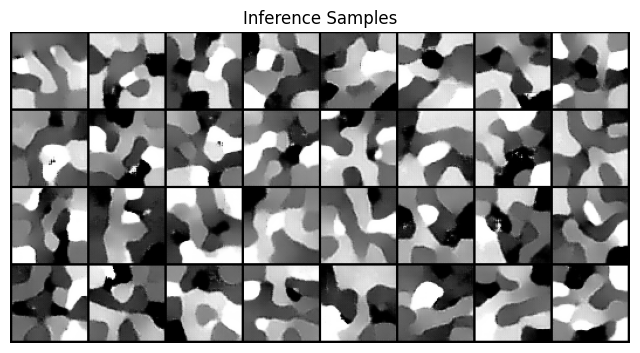

In [10]:
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

G.eval()
with torch.no_grad():
    z = torch.randn(64, Z_DIM, 1, 1, device=DEVICE)
    samples = G(z).cpu()

save_path = os.path.join(SAMPLES_DIR, f"infer_samples.png")
save_image(samples * 0.5 + 0.5, save_path, nrow=8)
print(f"Saved: {save_path}")

grid = make_grid(samples[:32] * 0.5 + 0.5, nrow=8, padding=2)
img = grid.permute(1, 2, 0).numpy()   # [H, W, C]

plt.figure(figsize=(8,8)); plt.axis("off"); plt.title("Inference Samples")
if img.shape[-1] == 1:                # 单通道(Grayscale)
    plt.imshow(img[..., 0], cmap="gray")
else:                                  # 多通道(RGB 等)
    plt.imshow(img)
plt.show()



## 9. Post-processing (Felzenszwalb segmentation only)
We keep a single, simple, and effective segmentation route: **Felzenszwalb segmentation**.

- Comments are in English.
- Training and sampling sections remain unchanged.


In [11]:

# === 9.1 Imports & helpers (English comments) ===
import os, json, math, numpy as np
import matplotlib.pyplot as plt

# skimage + scipy
try:
    from skimage import filters, morphology, measure, segmentation, exposure, color, util
    from skimage.color import rgb2gray
    from skimage.segmentation import felzenszwalb
    SKIMAGE_AVAILABLE = True
except Exception as _e:
    SKIMAGE_AVAILABLE = False
try:
    from scipy import ndimage as ndi
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

def _to_numpy01(x):
    """Convert tensor/list/PIL/numpy to float32 numpy array scaled to [0,1]."""
    # torch tensor
    try:
        import torch
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().float().numpy()
            if x.ndim == 4:
                x = x[0]
            if x.ndim == 3 and x.shape[0] in (1,3):
                x = np.transpose(x, (1,2,0))
    except Exception:
        pass
    # PIL
    try:
        from PIL import Image
        if isinstance(x, Image.Image):
            x = np.array(x)
    except Exception:
        pass

    x = np.asarray(x)
    if x.ndim == 3 and x.shape[-1] == 3:
        x = x.astype(np.float32) / (255.0 if x.dtype==np.uint8 else 1.0)
    else:
        x = x.astype(np.float32)
        if x.max() > 1.0:
            x = x / 255.0
        if x.ndim == 3 and x.shape[-1] == 1:
            x = x[..., 0]
    return np.clip(x, 0.0, 1.0).astype(np.float32)

def show_stage(title, img_np):
    """Display a single stage image (one figure)."""
    plt.figure(figsize=(5,5)); plt.title(title); plt.axis("off")
    plt.imshow(img_np)
    plt.show()


In [12]:

# === 9.2 Parameters (tunable knobs) — FZ only ===
PP = {
    # Preprocessing
    "use_clahe": True,
    "clahe_clip": 0.006,       # For 64x64, keep small to avoid amplifying noise
    "denoise": "gaussian",     # "gaussian" or "median"
    "sigma": 0,              # Used for gaussian
    "median_size": 3,          # Used for median

    # Felzenszwalb parameters
    "fz_scale": 0.00001, 
    "fz_sigma": 0.3,
    "fz_min_size": 100,
}

# How many generated samples to visualize
N_SHOW = 1

# Output directory for post-processing artifacts (FZ only)
POST_DIR = os.path.join(SAMPLES_DIR, "post_fz")
os.makedirs(POST_DIR, exist_ok=True)
print("Post outputs dir:", POST_DIR)


Post outputs dir: ./outputs_dcgan/samples/post_fz


In [13]:
# === 9.3 Preprocessing utilities (CLAHE / Denoise / Normalize) ===
def preprocess_gray(
    x,
    use_clahe=True,
    clahe_clip=0.006,
    denoise="gaussian",
    sigma=0.9,
    median_size=3,
    show_steps=False,
    stage_prefix="[Pre]"
):
    """Return gray image normalized to [0,1] after CLAHE and light denoise.
    If show_steps=True, visualize each intermediate stage via `show_stage`.
    """
    x_raw = x
    # (0) Show raw input
    if show_steps:
        show_stage(f"{stage_prefix} Input (raw)", np.clip(x_raw, 0, 1))

    # (1) RGB -> Gray if needed
    if SKIMAGE_AVAILABLE and x.ndim == 3:
        x = rgb2gray(x)
        if show_steps:
            show_stage(f"{stage_prefix} After RGB->Gray", np.clip(x, 0, 1))

    # (2) Clip & cast
    x = np.clip(x, 0, 1).astype(np.float32)
    if show_steps:
        show_stage(f"{stage_prefix} After clip [0,1]", x)

    # (3) Percentile normalization for robustness
    lo, hi = np.percentile(x, [1, 99])
    x = np.clip((x - lo) / (hi - lo + 1e-8), 0, 1).astype(np.float32)
    if show_steps:
        show_stage(f"{stage_prefix} After percentile norm (1-99%)", x)

    # (4) CLAHE (optional)
    if use_clahe and SKIMAGE_AVAILABLE:
        x = exposure.equalize_adapthist(x, clip_limit=float(clahe_clip), nbins=256).astype(np.float32)
        if show_steps:
            show_stage(f"{stage_prefix} After CLAHE (clip={clahe_clip})", x)

    # (5) Denoise
    if denoise == "median":
        if SKIMAGE_AVAILABLE:
            se = morphology.square(max(1, int(median_size)))
            try:
                x = filters.median(x, footprint=se).astype(np.float32)
            except TypeError:
                x = filters.median(x, selem=se).astype(np.float32)
        elif SCIPY_AVAILABLE:
            x = ndi.median_filter(x, size=max(1, int(median_size))).astype(np.float32)
        if show_steps:
            show_stage(f"{stage_prefix} After median denoise (k={median_size})", x)
    else:
        if SKIMAGE_AVAILABLE:
            x = filters.gaussian(x, sigma=float(sigma), preserve_range=True).astype(np.float32)
        elif SCIPY_AVAILABLE:
            x = ndi.gaussian_filter(x, sigma=float(sigma)).astype(np.float32)
        if show_steps:
            show_stage(f"{stage_prefix} After Gaussian denoise (σ={sigma})", x)

    # (6) Final clamp
    x = np.clip(x, 0, 1).astype(np.float32)
    if show_steps:
        show_stage(f"{stage_prefix} Output", x)

    return x



In [14]:
# === 9.5 Method 2: Felzenszwalb segmentation ===
def felzenszwalb_segment(img, scale=1.0, sigma=0.5, min_size=20, show_steps=False, stage_prefix="[FZ]"):
    """
    Felzenszwalb-based segmentation on a gray image in [0,1].
    If show_steps=True, visualize gray, label-color, overlay, and boundaries.
    """
    x = _to_numpy01(img)
    g = rgb2gray(x) if (SKIMAGE_AVAILABLE and x.ndim == 3) else x
    if show_steps:
        show_stage(f"{stage_prefix} Gray", g)

    # Segmentation
    seg = felzenszwalb(g, scale=float(scale), sigma=float(sigma), min_size=int(min_size))

    # Label colorization (for visualization only)
    if SKIMAGE_AVAILABLE:
        try:
            lbl_rgb = color.label2rgb(seg, bg_label=0)  # colorized labels
            if show_steps:
                show_stage(f"{stage_prefix} Labels (colorized)", np.clip(lbl_rgb, 0, 1))
        except Exception:
            lbl_rgb = None
    else:
        lbl_rgb = None

    # Overlay with gray image
    overlay = color.label2rgb(seg, image=g, bg_label=0, alpha=0.35)
    if show_steps:
        show_stage(f"{stage_prefix} Overlay (alpha=0.35)", np.clip(overlay, 0, 1))

    # Boundary visualization
    bnd_overlay = None
    if SKIMAGE_AVAILABLE:
        try:
            from skimage.segmentation import mark_boundaries
            bnd_overlay = mark_boundaries(g, seg, color=(1, 0, 0), mode="outer")
            if show_steps:
                show_stage(f"{stage_prefix} Boundaries (red)", np.clip(bnd_overlay, 0, 1))
        except Exception:
            bnd_overlay = None

    # Region properties / areas
    props = measure.regionprops(seg)
    areas = np.array([p.area for p in props], dtype=np.int64)

    out = {
        "gray": g,
        "labels": seg.astype(np.int32),
        "overlay": np.clip(overlay, 0, 1),
        "props": props,
        "areas": areas
    }
    if lbl_rgb is not None:
        out["labels_rgb"] = np.clip(lbl_rgb, 0, 1)
    if bnd_overlay is not None:
        out["boundaries"] = np.clip(bnd_overlay, 0, 1)
    return out



[Info] Using 1 in-memory samples.


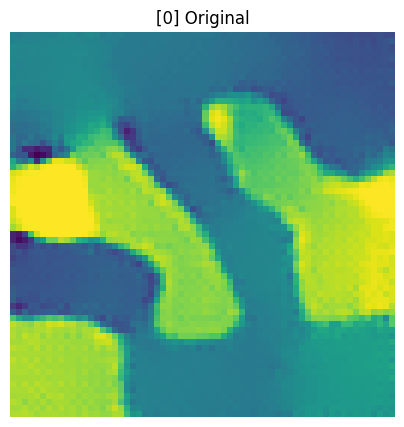

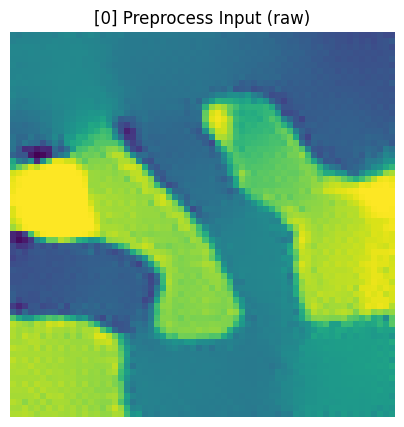

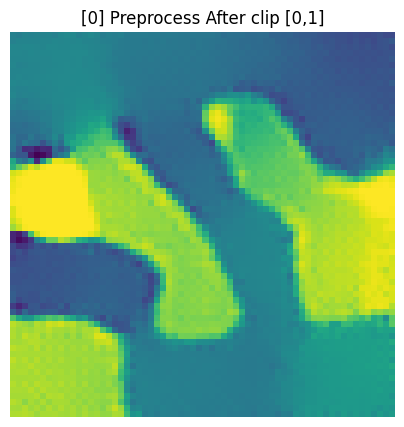

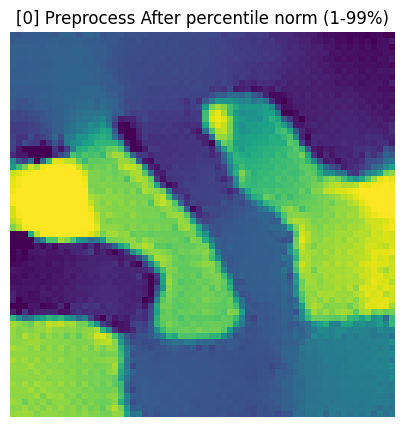

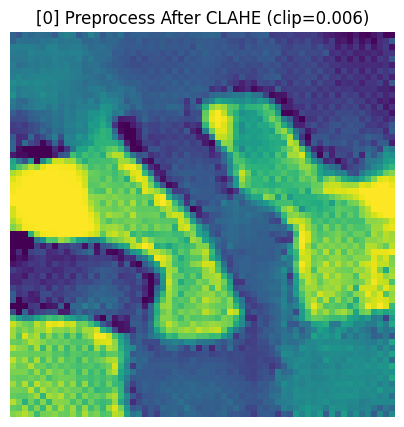

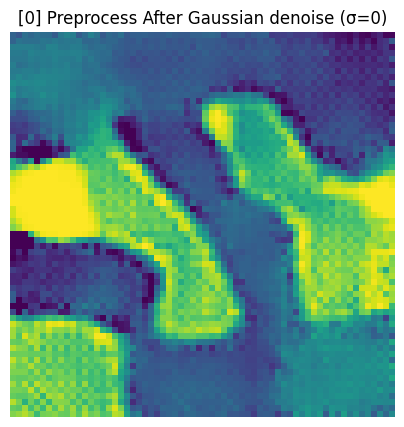

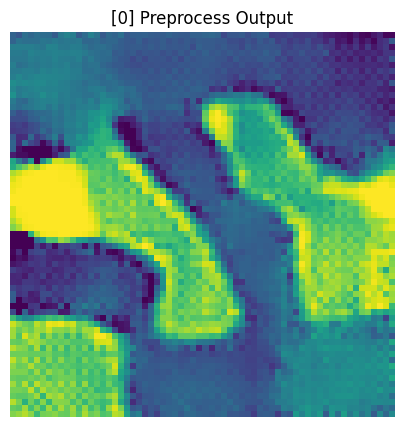

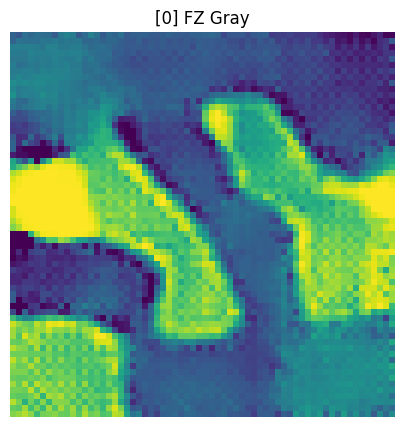

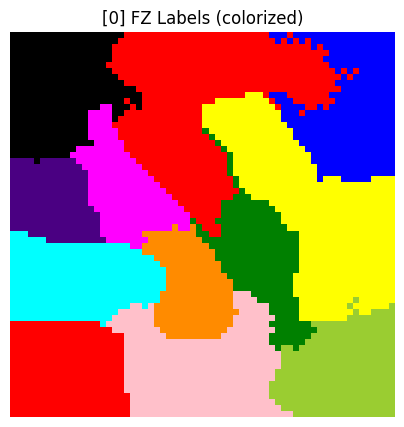

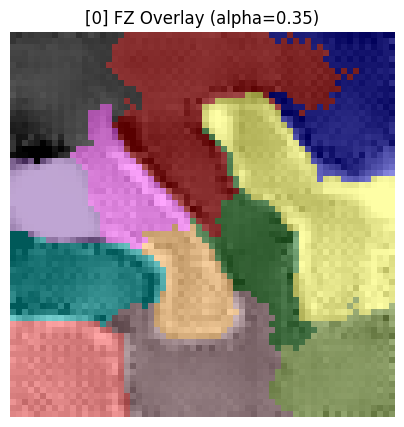

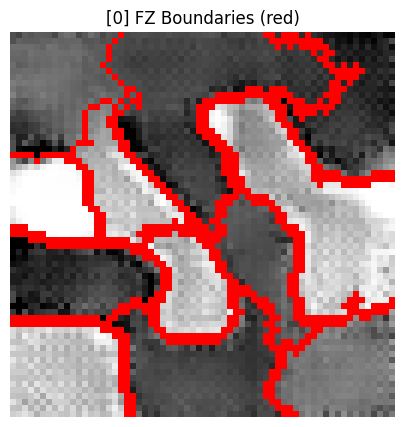

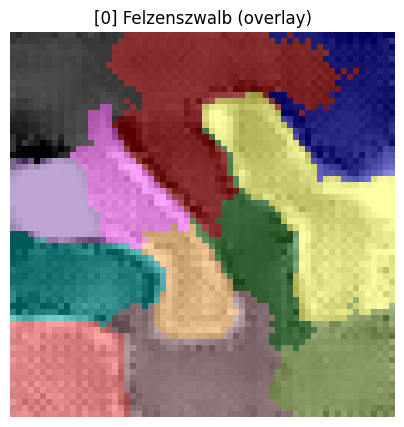

[0] Felzenszwalb regions=12


In [15]:
# === 9.6 Run on generated samples (FZ only, first N_SHOW) ===
# Try to use in-memory `samples`; otherwise fall back to the latest grid image on disk.
imgs_np = []
try:
    _ = samples  # from the sampling cell
    import torch
    S = int(min(N_SHOW, samples.shape[0]))
    for i_ in range(S):
        x = (samples[i_] * 0.5 + 0.5).detach().cpu().numpy()
        if x.shape[0] in (1, 3):
            x = np.transpose(x, (1, 2, 0))
        if x.shape[-1] == 1:
            x = x[..., 0]
        imgs_np.append(np.clip(x, 0.0, 1.0).astype(np.float32))
    print(f"[Info] Using {len(imgs_np)} in-memory samples.")
except Exception:
    pass

if len(imgs_np) == 0:
    grid_path = os.path.join(SAMPLES_DIR, sorted(os.listdir(SAMPLES_DIR))[-1]) if os.path.isdir(SAMPLES_DIR) and os.listdir(SAMPLES_DIR) else None
    if grid_path and os.path.exists(grid_path):
        from PIL import Image
        grid = np.array(Image.open(grid_path).convert("L")) / 255.0
        imgs_np = [grid.astype(np.float32)]
        print(f"[Info] Using grid image at {grid_path}")
    else:
        print("[Warn] No samples found; please run the sampling cell above.")

all_areas_fz = []

for idx, im in enumerate(imgs_np):
    # (A) Show original image
    show_stage(f"[{idx}] Original", im)

    # (B) Preprocess with step-by-step visualization
    x_prep = preprocess_gray(
        im,
        use_clahe=PP["use_clahe"],
        clahe_clip=PP["clahe_clip"],
        denoise=PP["denoise"],
        sigma=PP["sigma"],
        median_size=PP["median_size"],
        show_steps=True,
        stage_prefix=f"[{idx}] Preprocess"
    )

    # (C) Felzenszwalb segmentation with step-by-step visualization
    out_f = felzenszwalb_segment(
        x_prep,
        scale=PP["fz_scale"],
        sigma=PP["fz_sigma"],
        min_size=PP["fz_min_size"],
        show_steps=True,
        stage_prefix=f"[{idx}] FZ"
    )

    # (D) Final overlay (kept for backward compatibility; already shown above)
    show_stage(f"[{idx}] Felzenszwalb (overlay)", out_f["overlay"])

    # (E) Collect areas and print region count
    all_areas_fz.extend(list(out_f["areas"].astype(np.float64)))
    n_regions = len(np.unique(out_f["labels"]))
    print(f"[{idx}] Felzenszwalb regions={n_regions}")




[Progress] Generated 100/10000 images
[Progress] Generated 200/10000 images
[Progress] Generated 300/10000 images
[Progress] Generated 400/10000 images
[Progress] Generated 500/10000 images
[Progress] Generated 600/10000 images
[Progress] Generated 700/10000 images
[Progress] Generated 800/10000 images
[Progress] Generated 900/10000 images
[Progress] Generated 1000/10000 images
[Progress] Generated 1100/10000 images
[Progress] Generated 1200/10000 images
[Progress] Generated 1300/10000 images
[Progress] Generated 1400/10000 images
[Progress] Generated 1500/10000 images
[Progress] Generated 1600/10000 images
[Progress] Generated 1700/10000 images
[Progress] Generated 1800/10000 images
[Progress] Generated 1900/10000 images
[Progress] Generated 2000/10000 images
[Progress] Generated 2100/10000 images
[Progress] Generated 2200/10000 images
[Progress] Generated 2300/10000 images
[Progress] Generated 2400/10000 images
[Progress] Generated 2500/10000 images
[Progress] Generated 2600/10000 im

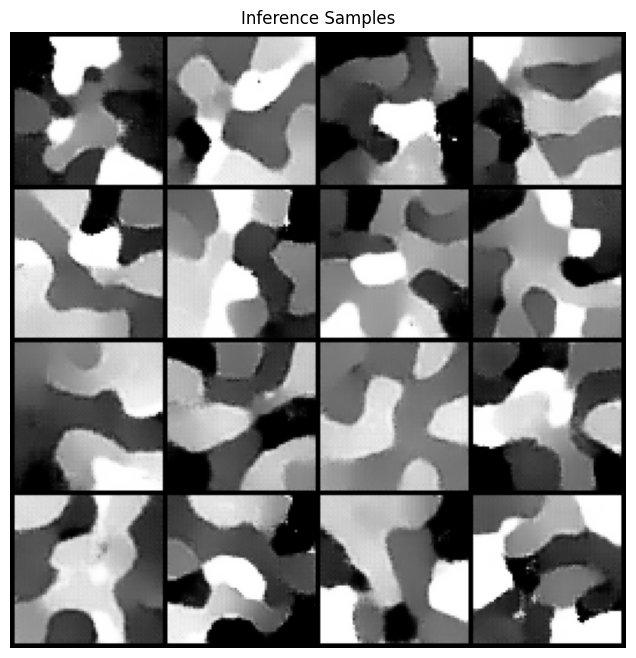

[Step] Converting samples to numpy...


Converting: 100%|██████████| 10000/10000 [00:00<00:00, 34699.72it/s]


[Step] Running Felzenszwalb segmentation with Code-1 style...


Segmenting: 100%|██████████| 10000/10000 [01:04<00:00, 155.74it/s]


[Step] Showing up to 32 example label maps (Felzenszwalb labels only)...


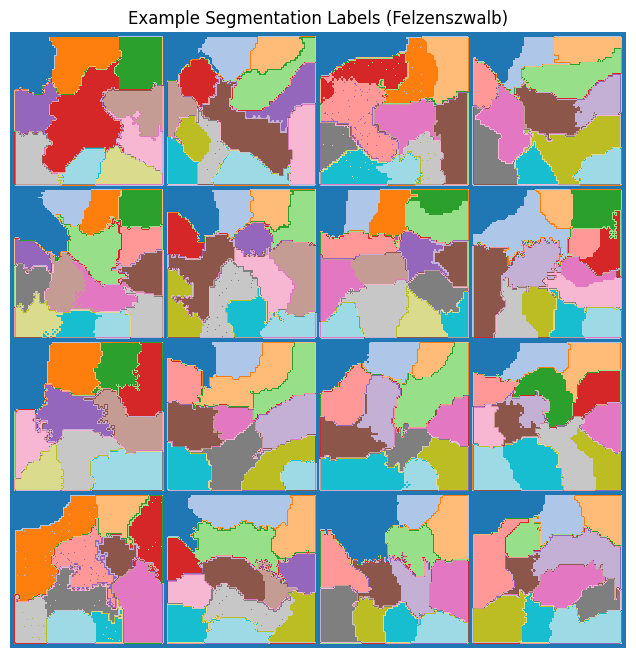

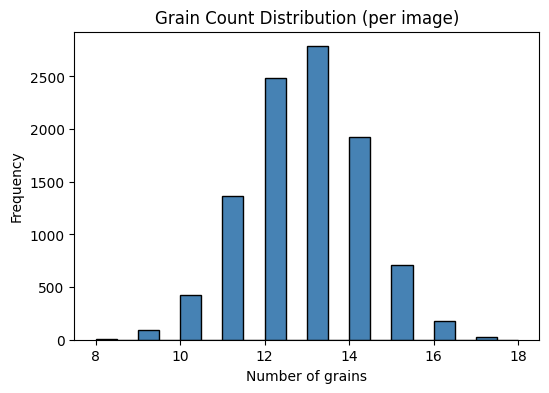

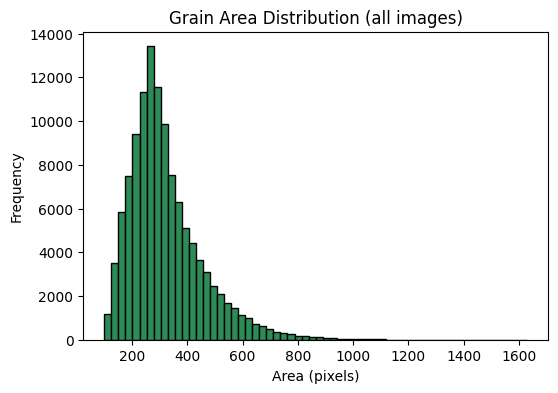

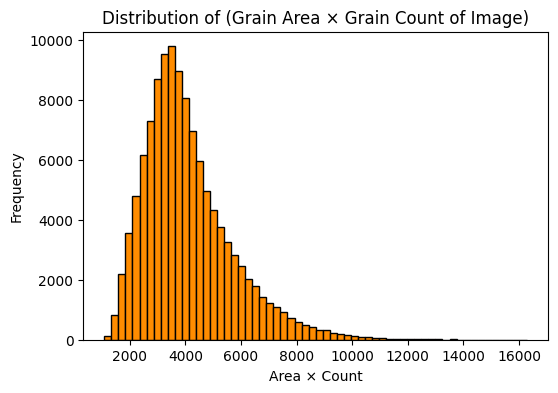

In [32]:
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import os, torch, numpy as np
from tqdm import tqdm

# ==== 1. Generate K images with GAN, one by one ====
K = 10000   # for example
imgs_list = []

G.eval()
with torch.no_grad():
    for i in range(K):
        z = torch.randn(1, Z_DIM, 1, 1, device=DEVICE)
        x = G(z).cpu()   # [1, C, H, W]
        imgs_list.append(x[0])  # save one image

        # Show progress every 100 images
        if (i + 1) % 100 == 0:
            print(f"[Progress] Generated {i+1}/{K} images")

# Stack into tensor [K, C, H, W]
samples = torch.stack(imgs_list, dim=0)

# Save a grid image
os.makedirs(SAMPLES_DIR, exist_ok=True)
save_path = os.path.join(SAMPLES_DIR, f"infer_samples.png")
save_image(samples * 0.5 + 0.5, save_path, nrow=8)
print(f"Saved: {save_path}")

# Show a grid of the first 16 samples
grid = make_grid(samples[:16] * 0.5 + 0.5, nrow=4, padding=2)
img = grid.permute(1, 2, 0).numpy()
plt.figure(figsize=(8,8)); plt.axis("off"); plt.title("Inference Samples")
if img.shape[-1] == 1:
    plt.imshow(img[..., 0], cmap="gray")
else:
    plt.imshow(img)
plt.show()


# ==== 2. Convert samples into numpy list for segmentation (match Code-1) ====
imgs_np = []
print("[Step] Converting samples to numpy...")
for i in tqdm(range(samples.shape[0]), desc="Converting"):
    x = (samples[i] * 0.5 + 0.5).numpy()   # ✅ 与第一段一致的反归一化到 [0,1]
    if x.shape[0] in (1, 3):
        x = np.transpose(x, (1, 2, 0))     # (H,W,C)
    if x.shape[-1] == 1:
        x = x[..., 0]                      # grayscale
    imgs_np.append(np.clip(x, 0.0, 1.0).astype(np.float32))


# ==== 3. Segment with Felzenszwalb (match Code-1: show original → preprocess → FZ) ====
grain_counts = []
all_areas = []
areas_per_image = []   # 便于后面 (area × count) 直接复用
labels_per_image = []  # 也可用于后续可视化

print("[Step] Running Felzenszwalb segmentation with Code-1 style...")

for idx, im in enumerate(tqdm(imgs_np, desc="Segmenting")):
    

    # (B) Preprocess with step-by-step visualization (与第一段一致)
    x_prep = preprocess_gray(
        im,
        use_clahe=PP["use_clahe"],
        clahe_clip=PP["clahe_clip"],
        denoise=PP["denoise"],
        sigma=PP["sigma"],
        median_size=PP["median_size"],
        
    )

    # (C) Felzenszwalb segmentation with step-by-step visualization (与第一段一致)
    out = felzenszwalb_segment(
        x_prep,
        scale=PP["fz_scale"],
        sigma=PP["fz_sigma"],
        min_size=PP["fz_min_size"],
        
    )

    

    # (E) Collect stats
    labels = out["labels"]
    areas = out["areas"].astype(np.float64)

    labels_per_image.append(labels)
    areas_per_image.append(areas)

    all_areas.extend(list(areas))
    n_regions = len(np.unique(labels))
    grain_counts.append(n_regions)
    


# ==== 3b. Show 32 example segmentation LABELS (not overlay), with consistent preprocessing ====
from torchvision.utils import make_grid

print("[Step] Showing up to 32 example label maps (Felzenszwalb labels only)...")

example_imgs = []
N_EXAMPLE = min(16, len(imgs_np))
for i in range(N_EXAMPLE):
    # 已在上面分割得到 labels_per_image[i]
    labels = labels_per_image[i].astype(np.float32)  # [H,W]
    # 归一化到 [0,1] 以便栅格拼接显示（类别色由 cmap 控制）
    if labels.max() > 0:
        labels_norm = labels / labels.max()
    else:
        labels_norm = labels
    label_tensor = torch.tensor(labels_norm).unsqueeze(0)  # shape [1,H,W]
    example_imgs.append(label_tensor)

if example_imgs:
    grid = make_grid(example_imgs, nrow=4, padding=2)
    img = grid.permute(1, 2, 0).numpy()
    plt.figure(figsize=(8,8)); plt.axis("off")
    plt.title("Example Segmentation Labels (Felzenszwalb)")
    plt.imshow(img[...,0], cmap="tab20")  # ✅ 仅显示 labels（非 overlay）
    plt.show()


# ==== 4. Plot distributions (unchanged) ====
plt.figure(figsize=(6,4))
plt.hist(grain_counts, bins=20, color="steelblue", edgecolor="black")
plt.title("Grain Count Distribution (per image)")
plt.xlabel("Number of grains"); plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(all_areas, bins=60, color="seagreen", edgecolor="black")
plt.title("Grain Area Distribution (all images)")
plt.xlabel("Area (pixels)"); plt.ylabel("Frequency")
plt.show()


# ==== 5. New metric: area * grain_count (per image) (unchanged in logic) ====
area_times_count = []
for i in range(len(imgs_np)):
    n_regions = grain_counts[i]                 # 该图的晶粒数
    areas = list(areas_per_image[i])            # 该图的所有晶粒面积
    for a in areas:
        area_times_count.append(a * n_regions)

plt.figure(figsize=(6,4))
plt.hist(area_times_count, bins=60, color="darkorange", edgecolor="black")
plt.title("Distribution of (Grain Area × Grain Count of Image)")
plt.xlabel("Area × Count")
plt.ylabel("Frequency")
plt.show()





In [17]:
import os, numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# ==== 1) Training set directory & file list ====
TRAIN_DIR = "/Users/shiyaogu/Documents/GANs/set"  # <-- change if needed
VALID_EXT = (".png", ".jpg", ".jpeg", ".tif", ".tiff")

# list files (case-insensitive extensions), ignore hidden files
all_files = [
    os.path.join(TRAIN_DIR, f)
    for f in os.listdir(TRAIN_DIR)
    if not f.startswith(".") and f.lower().endswith(VALID_EXT)
]
print(f"[Info] Found {len(all_files)} training images.")

# ==== 2) Accumulators ====
grain_counts = []
all_areas = []
area_times_count = []

# ==== 3) Iterate training images & segment (Felzenszwalb) ====
print("[Step] Running Felzenszwalb segmentation on training data...")
bad_files = 0

for f in tqdm(all_files, desc="Processing"):
    try:
        # Read as grayscale, robust to RGB/RGBA; output in [0,1] float32
        im = np.array(Image.open(f).convert("L"), dtype=np.float32) / 255.0
        if im.ndim != 2 or im.size == 0:
            raise ValueError("Invalid image shape")

        # Segment (FZ only)
        out = felzenszwalb_segment(
            im,
            scale=PP["fz_scale"],
            sigma=PP["fz_sigma"],
            min_size=PP["fz_min_size"],
        )

        # Grain count: use unique labels (do not drop label 0)
        n_regions = int(len(np.unique(out["labels"])))
        grain_counts.append(n_regions)

        # Grain areas
        areas = out["areas"].astype(np.float64).tolist()
        all_areas.extend(areas)

        # Area × Count for each grain in this image
        area_times_count.extend([a * n_regions for a in areas])

    except Exception as e:
        bad_files += 1
        # Optional: print(f"[Warn] Skip {f}: {e}")
        continue

print(f"[Info] Done. Valid images: {len(grain_counts)}, Skipped: {bad_files}")

# ==== 4) Plot distributions ====
plt.figure(figsize=(6,4))
plt.hist(grain_counts, bins=40, color="steelblue", edgecolor="black")
plt.title("Grain Count Distribution (training data)")
plt.xlabel("Number of grains per image"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(all_areas, bins=80, color="seagreen", edgecolor="black")
plt.title("Grain Area Distribution (training data)")
plt.xlabel("Area (pixels)"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(area_times_count, bins=80, color="darkorange", edgecolor="black")
plt.title("Distribution of (Grain Area × Grain Count) (training data)")
plt.xlabel("Area × Count"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/shiyaogu/Documents/GANs/set'